# Importing packages and defining functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import find_peaks

def clean_peaks_x(row_raw, quant, dist = 8, plot: bool = True, ax = None, title = None):
    
    ns = np.arange(len(row_raw))
    fit = np.polyfit(ns, row_raw, deg = 1)
    row = row_raw - fit[0]*ns + fit[1]
    x_i, x_heights = find_peaks(row, height = (np.quantile(row, quant), np.max(row) + 1.), distance = dist)
    if plot:
        if ax == None:
            fig, ax = plt.subplots()
        ax.plot(row)
        ax.axhline(np.quantile(row, quant))
        ax.plot(x_i, x_heights['peak_heights'],'+', color = 'orange')
        if title != None:
            ax.set_title(title)
    return x_i

def clean_peaks_y(col_raw, quant, dist = 8, plot: bool = True, ax = None, title = None):
    ns = np.arange(len(col_raw))
    fit = np.polyfit(ns, col_raw, deg = 1)
    col = col_raw - fit[0]*ns + fit[1]
    y_i, y_heights  = find_peaks(col, height = (np.quantile(col, quant), np.max(col) + 1.), distance = dist)
    if plot:
        if ax == None:
            fig, ax = plt.subplots()
        ax.plot(col)
        ax.axhline(np.quantile(col, quant))
        ax.plot(y_i, y_heights['peak_heights'],'+', color = 'orange')
        if title != None:
            ax.set_title(title)
    return y_i

def clean_peaks(data_raw, quant = 0.7, dist: int = 8, plot: bool = False, ax = None, title = None):
    ns = np.arange(len(data_raw))
    fit = np.polyfit(ns, data_raw, deg = 1)
    data = data_raw - fit[0]*ns - fit[1]
    peak_i, peak_h = find_peaks(data, height = (np.quantile(data, quant), np.max(data) + 1.), distance = dist)
    if plot:
        if ax == None:
            fig, ax = plt.subplots()
        ax.plot(data)
        ax.axhline(np.quantile(data, quant))
        ax.plot(peak_i, peak_h['peak_heights'],'+', color = 'orange')
        if title != None:
            ax.set_title(title)
    return peak_i

def calc_spacing(peak_i, plot: bool = False, ax = None, title = None):
    space = [peak_i[i+1] - peak_i[i] for i in range(len(peak_i) - 1)]
    if plot:
        if ax == None:
            fig, ax = plt.subplots(1)
        ax.bar(np.arange(len(space)), space)
        if title != None:
            ax.set_title(title)
    return space


def square_lattice_peaks(AFM_input, x0, y0, plot: bool = False):
    # Collect peaks for x0 and y0
    row_raw = AFM_input[y0]
    x0_i = clean_peaks(data_raw = row_raw, quant = 0.8, plot = plot)
    
    col_raw = [AFM_input[i][x0] for i in range(len(AFM_input))]
    y0_i = clean_peaks(data_raw = col_raw, quant = 0.8, plot = plot)
    
    # Calc gap positions for other peaks
    x0_space = calc_spacing(peak_i = x0_i)
    y0_space = calc_spacing(peak_i = y0_i)

    x_gaps =np.array([x0_i[i] + int(x0_space[i]/2) for i in range(len(x0_i) - 1)])
    y_gaps = np.array([y0_i[i] + int(y0_space[i]/2) for i in range(len(y0_i) - 1)])

    x_gaps[np.argmin(abs(x_gaps - x0))] = x0
    y_gaps[np.argmin(abs(y_gaps - y0))] = y0

    # print('1', len(x0_i), len(y0_i))
    # Collect other peaks (if len is same, remember cutoff to avoid features outside of array)
    y_xp = []
    x_xpeaks = []
    for y in y_gaps:
        if y != y0:
            # fig, ax = plt.subplots()
            # ax.imshow(img_rot)
            # ax.axhline(y, color = 'red')
            # plt.show()
            row_raw = AFM_input[y][max(0, x0_i[0] - int(x0_space[0]/2)):x0_i[-1] + int(x0_space[-1]/2)]
            x_i = clean_peaks(data_raw = row_raw, plot = plot) + max(0, x0_i[0] - int(x0_space[0]/2))
            # plt.show()
            # print('X', len(x_i))
            if len(x_i) == len(x0_i):
                x_xpeaks.append(x_i)
                y_xp.append(y)
        else:
            x_xpeaks.append(x0_i)
            y_xp.append(y)

    x_yp = []
    y_ypeaks = []
    for x in x_gaps:
        if x != x0:
            # fig, ax = plt.subplots()
            # ax.imshow(img_rot)
            # ax.axvline(x, color = 'red')
            # plt.show()
            # print(x)
            col_raw = [AFM_input[i][x] for i in range(len(AFM_input))][max(0, y0_i[0] - int(y0_space[0]/2)):y0_i[-1] + int(y0_space[-1]/2)]
            y_i = clean_peaks(data_raw = col_raw, plot = plot) + max(0, y0_i[0] - int(y0_space[0]/2))
            # plt.show()
            # print('Y', len(y_i))
            if len(y_i) == len(y0_i):
                y_ypeaks.append(y_i)
                x_yp.append(x)
        else:
            y_ypeaks.append(y0_i)
            x_yp.append(x)
    
    return ((np.array(x_xpeaks), np.array(y_xp)), (np.array(x_yp), np.array(y_ypeaks)))

def square_lattice_vertices(AFM_input, MFM_input, x0, y0, plot: bool = False):
    ((x_xpeaks, y_xp), (x_yp, y_ypeaks)) = square_lattice_peaks(AFM_input, x0, y0, plot = False)

    # print(len(y_xp), len(x_yp))
    # Approximate x and y positions
    mid_x = int((x_yp[0] + x_yp[-1])/2)
    mid_y = int((y_xp[0] + y_xp[-1])/2)
    mid_xpeaks = x_xpeaks[np.argmin(abs(y_xp - mid_y))]
    mid_ypeaks = y_ypeaks[np.argmin(abs(x_yp - mid_x))]
    # print('index', x_yp[np.argmin(abs(x_yp - mid_x))])
    
    nx, ny = (mid_xpeaks[-1] - mid_xpeaks[0])//(len(mid_xpeaks) - 1), (mid_ypeaks[-1] - mid_ypeaks[0])//(len(mid_ypeaks) - 1)
    
    # vrtx_Tcoords = np.zeros((len(mid_ypeaks), len(mid_xpeaks), 2))
    vrtx_Tcoords = np.zeros((len(mid_ypeaks) - 2, len(mid_xpeaks) - 2, 2))
    vrtx_box = np.zeros((vrtx_Tcoords.shape[0], vrtx_Tcoords.shape[1], ny, nx))
    
    for i_y in range(1, len(mid_ypeaks) - 1):
        y_est = mid_ypeaks[i_y]
        coords_temp = []
        for i_x in range(1, len(mid_xpeaks) - 1):
            # print(mid_xpeaks)
            x_est = mid_xpeaks[i_x]
            # print(x_est)
            # print(x_yp)
            # print([xs for xs in x_yp if xs<=x_est])
            i_xpeaks = np.argmax([xs for xs in x_yp if xs<=x_est])
            i_ypeaks = np.argmax([ys for ys in y_xp if ys<=y_est]) 
            y0, y1 = y_ypeaks[i_xpeaks][i_y], y_ypeaks[i_xpeaks + 1][i_y]
            x0, x1 = x_xpeaks[i_ypeaks][i_x], x_xpeaks[i_ypeaks + 1][i_x]
            dx = abs(x_yp[i_xpeaks + 1] - x_yp[i_xpeaks])
            dy = abs(y_xp[i_ypeaks + 1] - y_xp[i_ypeaks])
            if x1<x0:
                x0, x1 = x1, x0
            if y1<y0:
                y0, y1 = y1, y0
            # xT = x0 + dx*(x1 - x0)*(y0 + (y1 - y0)*x0/dx)/(dx*dy - (y1 - y0)*(x1 - x0))
            # yT = y0 + dy*(y1 - y0)*(x0 + (x1 - x0)*y0/dy)/(dx*dy - (y1 - y0)*(x1 - x0))
            # coords_temp.append([xT, yT])
            coords_temp.append([int((x0 + x1)/2), int((y0 + y1)/2)])
            vrtx_box[i_y - 1, i_x - 1, :, :] = MFM_input[int((y0 + y1)/2) - int(ny/2): int((y0 + y1)/2) + int(ny/2), int((x0 + x1)/2) - int(nx/2): int((x0 + x1)/2) + int(nx/2)]
        # vrtx_Tcoords[i_y][1: len(mid_xpeaks) - 1] = np.array(coords_temp)
        vrtx_Tcoords[i_y - 1][:] = np.array(coords_temp)
    return vrtx_Tcoords, vrtx_box

def iceil(float):
    return int(np.ceil(float))


def square_lattice_bars(AFM_input, MFM_input, x0, y0, plot: bool = False):
    ((x_xpeaks, y_xp), (x_yp, y_ypeaks)) = square_lattice_peaks(AFM_input, x0, y0, plot = False)

    # print(len(y_xp), len(x_yp))
    # Approximate x and y positions
    mid_x = int((x_yp[0] + x_yp[-1])/2)
    mid_y = int((y_xp[0] + y_xp[-1])/2)
    mid_xpeaks = x_xpeaks[np.argmin(abs(y_xp - mid_y))]
    mid_ypeaks = y_ypeaks[np.argmin(abs(x_yp - mid_x))]
    # print('index', x_yp[np.argmin(abs(x_yp - mid_x))])
    
    # wx, wy = int((mid_xpeaks[-1] - mid_xpeaks[0])/(2*(len(mid_xpeaks) - 1))), int((mid_ypeaks[-1] - mid_ypeaks[0])/(2*(len(mid_ypeaks) - 1))) # Need to change this for bar dim
    lx, ly = iceil((mid_xpeaks[-1] - mid_xpeaks[0])/(len(mid_xpeaks) - 1)), iceil((mid_ypeaks[-1] - mid_ypeaks[0])/(len(mid_ypeaks) - 1))
    print('LENGTH', lx, ly)

    vrtx_coords = np.zeros((len(mid_ypeaks), len(mid_xpeaks), 2))
    vrtx_box = np.zeros((vrtx_coords.shape[0], vrtx_coords.shape[1], iceil(ly/2), iceil(lx/2)))
    
    for i_y in range(len(mid_ypeaks)): 
        y_est = mid_ypeaks[i_y]
        coords_temp = []
        for i_x in range(len(mid_xpeaks)): 
            x_est = mid_xpeaks[i_x]
            
            # Select closest pair of y measurements
            def select_index(estimate, ordered_array):
                if estimate < ordered_array[0]:
                    index = 0
                elif estimate > ordered_array[-1]:
                    index = -2
                else:
                    i = 1
                    while estimate > ordered_array[i]:
                        i += 1
                    index = i - 1
                return index, ordered_array[index]
            
            i_y_xp, yx0 = select_index(y_est, y_xp)
            i_x_yp, xy0 = select_index(x_est, x_yp)
            
            # Take measurements of closest x0, x1 and y0, y1
            x0, x1 = x_xpeaks[i_y_xp][i_x], x_xpeaks[i_y_xp + 1][i_x] 
            y0, y1 = y_ypeaks[i_x_yp][i_y], y_ypeaks[i_x_yp + 1][i_y]

            dx = x_yp[i_x_yp + 1] - x_yp[i_x_yp]
            dy = y_xp[i_y_xp + 1] - y_xp[i_y_xp]

            if x0 == x1:
                xT = x0
            else:
                xT = (xy0*(y1 - y0)/dx - x0*dy/(x1 - x0) + yx0 - y0)/((y1 - y0)/dx - dy/(x1 - x0))
            yT = round((y1 - y0)*(xT - xy0)/dx + y0)
            xT = round(xT)
            coords_temp.append([xT, yT])
            # vrtx_bar[i_y, i_x, :, :] = MFM_input[int((y0 + y1)/2) - int(ny/2): int((y0 + y1)/2) + int(ny/2), int((x0 + x1)/2) - int(nx/2): int((x0 + x1)/2) + int(nx/2)]
            # print(yT, xT)
            # print(yT - int(ly/2), yT + int(ly/2), xT - int(lx/2), xT + int(lx/2) + 1)
            vrtx_box[i_y, i_x, :, :] = MFM_input[yT - int(ly/4): yT + iceil(ly/4), xT - int(lx/4): xT + iceil(lx/4)]
        # vrtx_Tcoords[i_y][1: len(mid_xpeaks) - 1] = np.array(coords_temp)
        vrtx_coords[i_y][:] = np.array(coords_temp)
    vrtx_coords = vrtx_coords.astype('int32')

    xbars_AFM = np.zeros((vrtx_coords.shape[0], vrtx_coords.shape[1] - 1, iceil(ly/2), lx))
    ybars_AFM = np.zeros((vrtx_coords.shape[0] - 1, vrtx_coords.shape[1], ly, iceil(lx/2)))
    xbars = np.zeros((vrtx_coords.shape[0], vrtx_coords.shape[1] - 1, iceil(ly/2), lx))
    ybars = np.zeros((vrtx_coords.shape[0] - 1, vrtx_coords.shape[1], ly, iceil(lx/2)))

    if vrtx_coords.shape[0] == vrtx_coords.shape[1]:
        for i_l in range(vrtx_coords.shape[0]):
            for i_s in range(vrtx_coords.shape[0] - 1):
                xbars[i_l, i_s, :, :] = MFM_input[vrtx_coords[i_l, i_s, 1] - int(ly/4): vrtx_coords[i_l, i_s, 1] + iceil(ly/4), vrtx_coords[i_l, i_s, 0]: vrtx_coords[i_l, i_s, 0] + lx]
                ybars[i_s, i_l, :, :] = MFM_input[vrtx_coords[i_s, i_l, 1]: vrtx_coords[i_s, i_l, 1] + ly, vrtx_coords[i_s, i_l, 0] - int(lx/4): vrtx_coords[i_s, i_l, 0] + int(np.ceil(lx/4))]
                xbars_AFM[i_l, i_s, :, :] = AFM_input[vrtx_coords[i_l, i_s, 1] - int(ly/4): vrtx_coords[i_l, i_s, 1] + iceil(ly/4), vrtx_coords[i_l, i_s, 0]: vrtx_coords[i_l, i_s, 0] + lx]
                ybars_AFM[i_s, i_l, :, :] = AFM_input[vrtx_coords[i_s, i_l, 1]: vrtx_coords[i_s, i_l, 1] + ly, vrtx_coords[i_s, i_l, 0] - int(lx/4): vrtx_coords[i_s, i_l, 0] + iceil(lx/4)]
    else:
        raise NotImplmentedError("No support for non-square arrays yet")

    return vrtx_coords, vrtx_box, (xbars, ybars), (xbars_AFM, ybars_AFM) #, (xbars_test, ybars_test) 

def calc_brightness(image):
    return np.sum(image)/(image.shape[0]*image.shape[1])

# def test_macro



def rot_image(image, angle):
    height, width = image.shape[:2]
    center = (int(width/2), int(height/2))
    rot_matrix = cv2.getRotationMatrix2D(center, angle, 1)
    return cv2.warpAffine(image, rot_matrix,(height, width))

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

class DynamicCNN(nn.Module):
    def __init__(self, filter_list, num_classes = 4, kerne_size = 3):
        super(DynamicCNN, self).__init__()
        self.layers = nn.ModuleList()
        in_channels = 1  # Assuming the input has one channel, change if different

        for filters in filter_list:
            conv_layer = nn.Conv2d(in_channels, filters, kernel_size=3, padding=1)
            self.layers.append(conv_layer)
            self.layers.append(nn.ReLU())
            self.layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            in_channels = filters

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(in_channels * (image_size // 2**len(filter_list))**2, num_classes)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

# Example Usage
net = DynamicCNN([8, 16], num_classes=4)
print(net)



## TRAINING AND TESTING

# Assuming the DynamicCNN class has already been defined as previously discussed

# Parameters
num_epochs = 5
batch_size = 64
learning_rate = 0.001
image_size = 28  # Example image size, e.g., for MNIST
num_classes = 4  # Number of classes
filter_list = [16, 32, 64]  # Example filter sizes for each convolutional layer

# Dataset (using MNIST for demonstration, modify accordingly)
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DynamicCNN(filter_list, num_classes=num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        # Forward pass
        output = model(data)
        loss = criterion(output, target)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (batch_idx+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

# Test the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    print(f'Accuracy of the network on the test images: {100 * correct / total}%')




# Loading AFM and MFM images (.txt files, pre-processed in Gwyddion)

In [10]:
from MFM_read_toolkit import square_lattice_bars, rot_image
import numpy as np
import matplotlib.pyplot as plt


In [6]:
base_path = "C:\\Users\\tobia\\OneDrive - Imperial College London\\PhD\\AOMS_DMD\\"
img_AFM = np.loadtxt("diamond_scans/diamond_AFM.txt")
img_MFM = np.loadtxt("diamond_scans/diamond_MFM.txt")

# Plot AFM image, rotate AFM and MFM so that square lattice is straight (approx) and define input x0 and y0 to intersect clean lattice bars

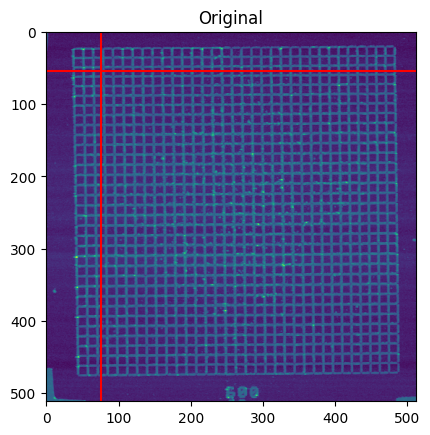

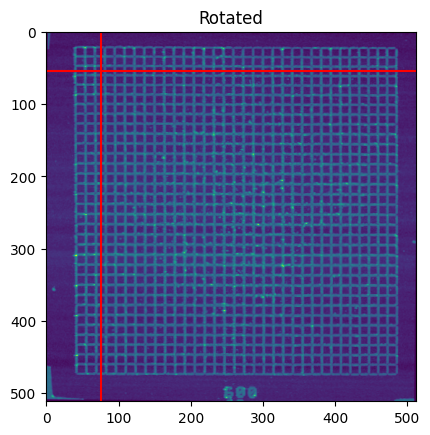

In [11]:
x0 = 75
y0 = 54

# Plotting unrotated AFM image for reference, risk that horizontal reference line (y0) will cross horizontal lattice bar
fig, ax = plt.subplots()
ax.imshow(img_AFM)
ax.axhline(y0, color = 'red')
ax.axvline(x0, color = 'red')
plt.title('Original')
plt.show()

# Rotating 
AFM_rot = rot_image(img_AFM, angle = -0.6)
MFM_rot = rot_image(img_MFM, angle = -0.6)

# Plotting rotated AFM image for reference
fig, ax = plt.subplots()
ax.imshow(AFM_rot)
ax.axhline(y0, color = 'red')
ax.axvline(x0, color = 'red')
plt.title('Rotated')
plt.show()

# Extract vertex coordinates and vertex boxes

(512, 512)
(512, 512)
(34, 34, 2)


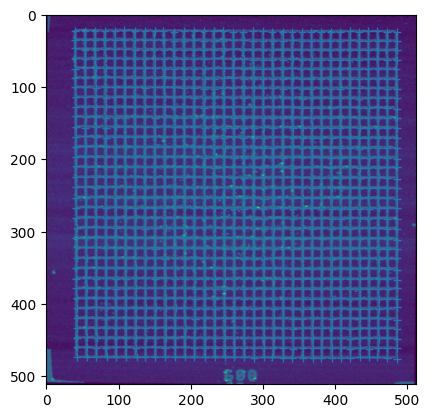

In [14]:
# vrtx_coords, vrtx_box = square_lattice_vertices(AFM_input = AFM_rot, MFM_input = MFM_rot, x0 = x0, y0 = y0, plot = False)
print(MFM_rot.shape)
print(AFM_rot.shape)
vrtx_coords, vrtx_box, (xbars, ybars) = square_lattice_bars(AFM_input = AFM_rot, MFM_input = MFM_rot, x0 = x0, y0 = y0)
xs = [elem[0] for lst in vrtx_coords for elem in lst]
ys = [elem[1] for lst in vrtx_coords for elem in lst]
print(vrtx_coords.shape)
fig, ax = plt.subplots()
ax.imshow(AFM_rot)
ax.plot(xs, ys, '+')
plt.show()

In [6]:
# vrtx_coords, vrtx_box = square_lattice_vertices(AFM_input = AFM_rot, MFM_input = MFM_rot, x0 = x0, y0 = y0, plot = False)
vrtx_coords, vrtx_box = square_lattice_vertices(AFM_input = AFM_rot, MFM_input = MFM_rot, x0 = x0, y0 = y0, plot = False)
xs = [elem[0] for lst in vrtx_coords for elem in lst]
ys = [elem[1] for lst in vrtx_coords for elem in lst]
print(vrtx_coords.shape)
fig, ax = plt.subplots()
ax.imshow(AFM_rot)
ax.plot(xs, ys, '+')
plt.show()

ValueError: could not broadcast input array from shape (12,12) into shape (13,13)

# Plot some MFM vertex boxes to check if it worked

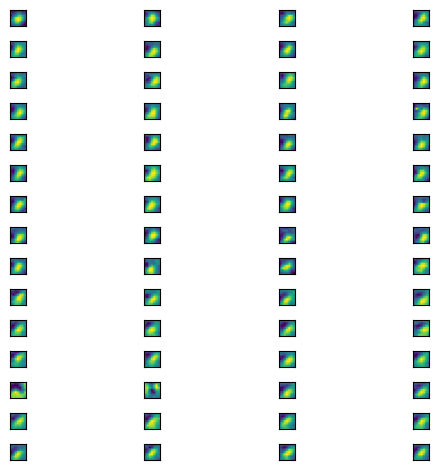

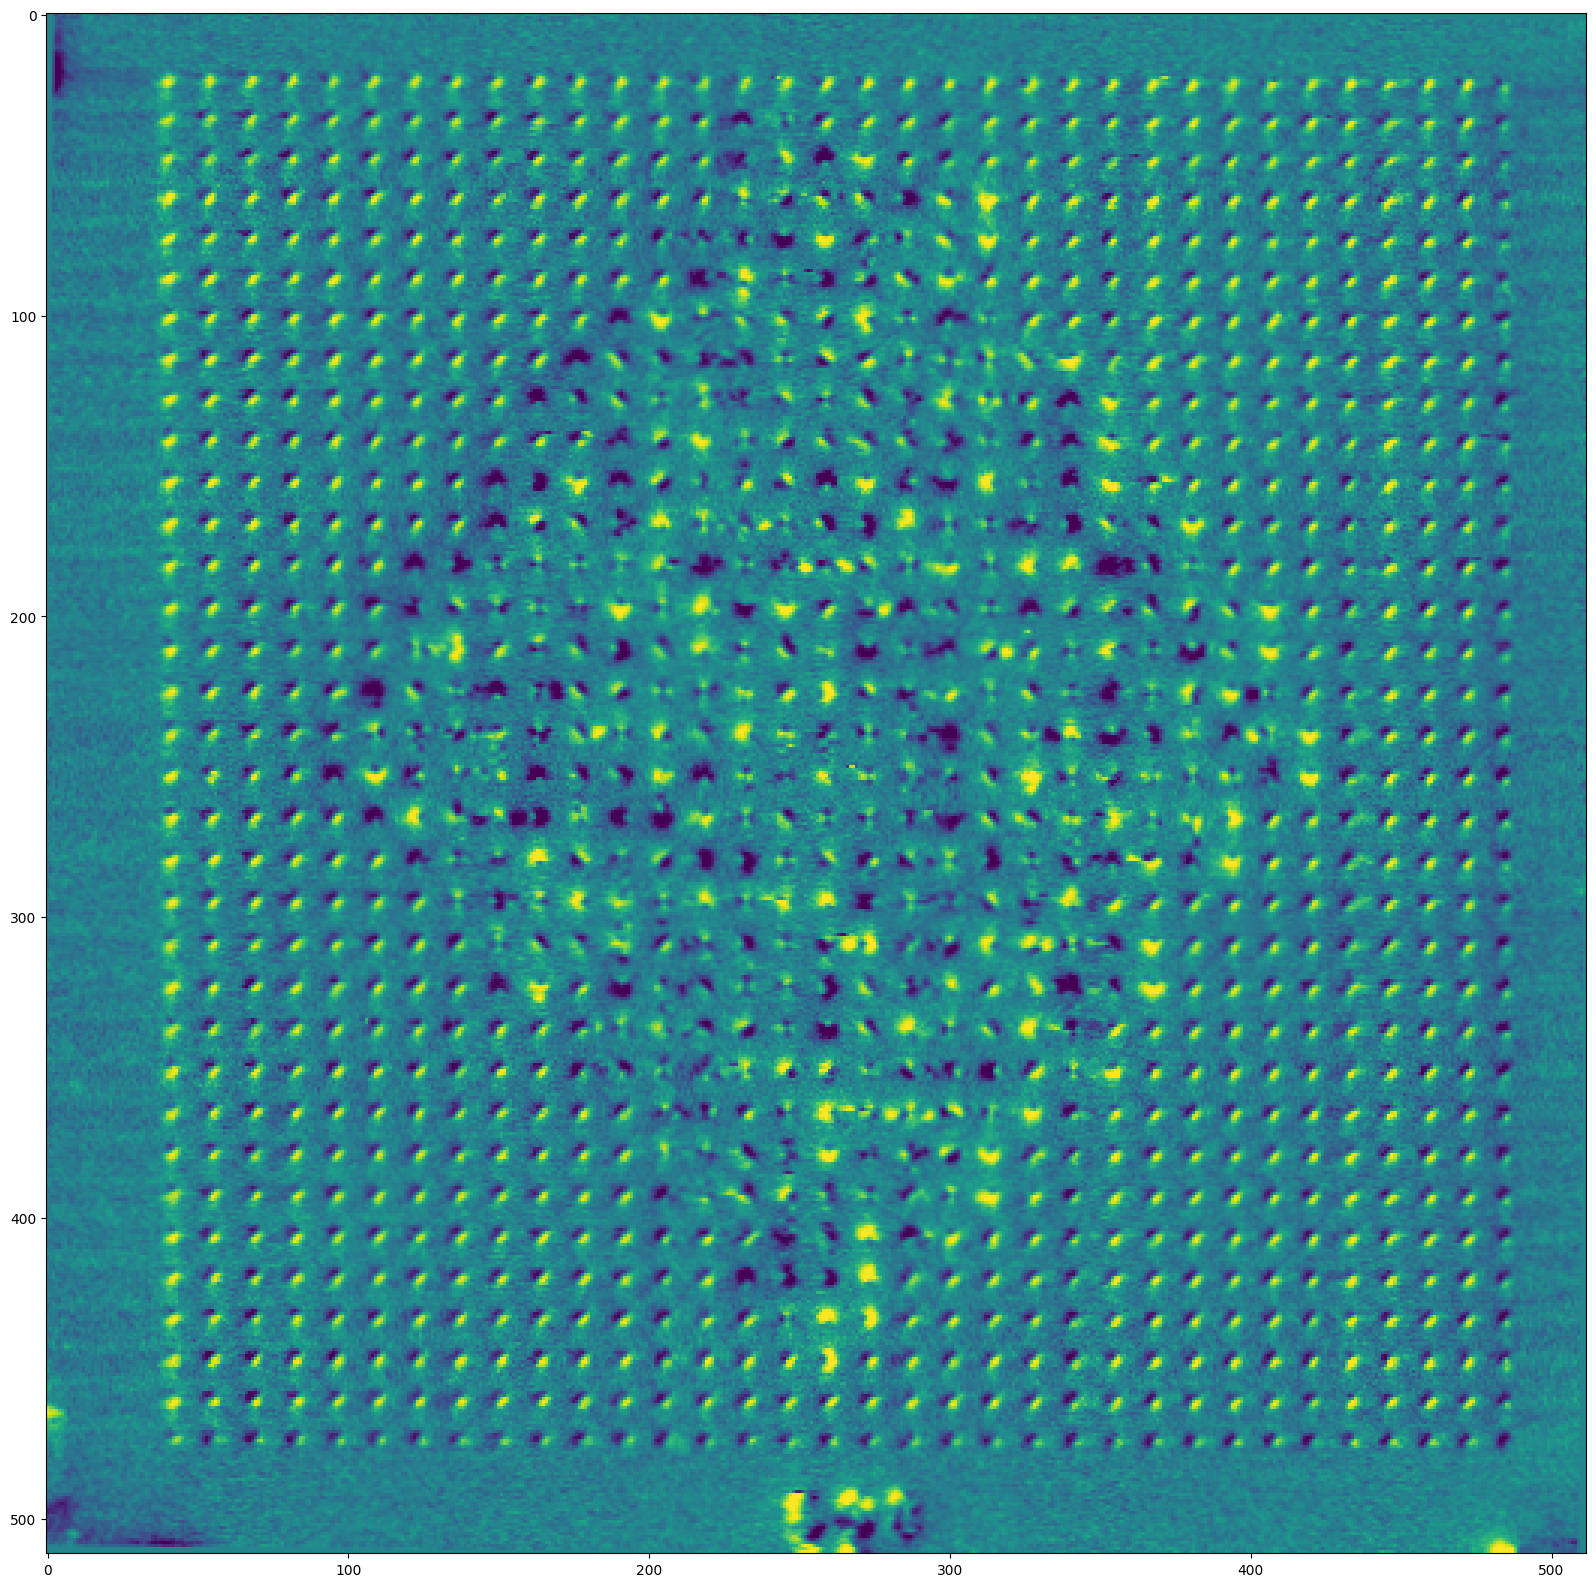

In [15]:
# vrtx_box = vrtx_box[1:-1,1:-1, :, :]

fig, axes = plt.subplots(15, 4)
for i, ax in enumerate(axes.flatten()):
    ax.imshow(vrtx_box.reshape(vrtx_box.shape[0]*vrtx_box.shape[1], vrtx_box.shape[2], vrtx_box.shape[3])[i])
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize = (20, 20))
ax.imshow(MFM_rot)
plt.show()

UnboundLocalError: local variable 't_vrtx' referenced before assignment

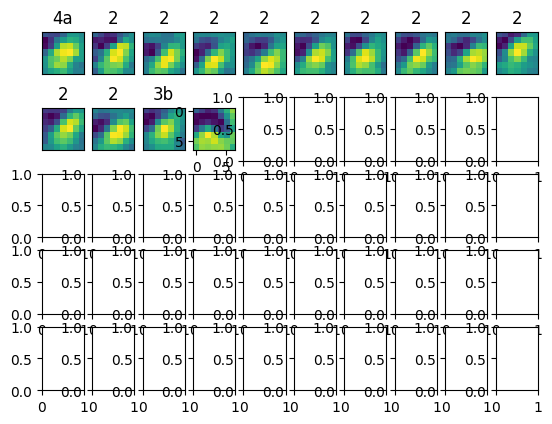

In [6]:
vrtx_box_center = vrtx_box[1:-1, 1:-1, :, :]
center_flat = vrtx_box_center.reshape(vrtx_box_center.shape[0]*vrtx_box_center.shape[1], vrtx_box_center.shape[2], vrtx_box_center.shape[3])

def mean_bin(array):
    if np.mean(array) > 0:
        return 1
    if np.mean(array) < 0:
        return -1

def vrtx_type(box1):
    top_lst, bottom_lst, right_lst, left_lst = [], [], [], []
    background = np.mean([box1[0,0], box1[-1,0], box1[0,-1], box1[-1,-1]])
    for j in range(box1.shape[0]):
        for i in range(box1.shape[1]):
            if j < box1.shape[1]*i/box1.shape[0] and j < -(box1.shape[1] - 1)*(i/(box1.shape[0] - 1) - 1): # blue and orange 
                top_lst.append(box1[j,i])
            if j > box1.shape[1]*i/box1.shape[0] and j > -(box1.shape[1] - 1)*(i/(box1.shape[0] - 1) - 1):
                bottom_lst.append(box1[j,i])
            if j > box1.shape[1]*i/box1.shape[0] and j < -(box1.shape[1] - 1)*(i/(box1.shape[0] - 1) - 1):
                right_lst.append(box1[j,i])
            if j < box1.shape[1]*i/box1.shape[0] and j > -(box1.shape[1] - 1)*(i/(box1.shape[0] - 1) - 1):
                left_lst.append(box1[j,i])
    top, bottom, right, left = mean_bin(top_lst - background), mean_bin(bottom_lst - background), mean_bin(right_lst - background), mean_bin(left_lst - background)

    if np.sum([top, bottom, right, left]) == 0:
        if top == bottom:
            t_vrtx = '1'
        else:
            t_vrtx = '2'
    if np.sum([top, bottom, right, left]) == 4:
        t_vrtx = '4a'
    if np.sum([top, bottom, right, left]) == -4:
        t_vrtx = '4b'
    if np.sum([top, bottom, right, left]) == 2:
        t_vrtx = '3a'
    if np.sum([top, bottom, right, left]) == 2:
        t_vrtx = '3b'
    return t_vrtx


fig, axes = plt.subplots(5, 10)
for i, ax in enumerate(axes.flatten()):
    ax.imshow(center_flat[i])
    t_vrtx = vrtx_type(center_flat[i])
    ax.set_title(t_vrtx)
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
plt.show()


box1 = center_flat[2]
fig, ax = plt.subplots()
ax.imshow(box1)
xs = np.linspace(0, box1.shape[0] - 1, 100)
ax.plot(xs, box1.shape[1]*xs/box1.shape[0])
ax.plot(xs, -(box1.shape[1] - 1)*(xs/(box1.shape[0] - 1) - 1))
plt.show()

# fig, ax = plt.subplots()
# ax.imshow(box1)
# xs = np.linspace(0, box1.shape[0] - 1, 100)
# ax.plot(xs, box1.shape[1]*xs/box1.shape[0]) # blue
# ax.plot(xs, -(box1.shape[1] - 1)*(xs/(box1.shape[0] - 1) - 1)) #orange
# plt.show()

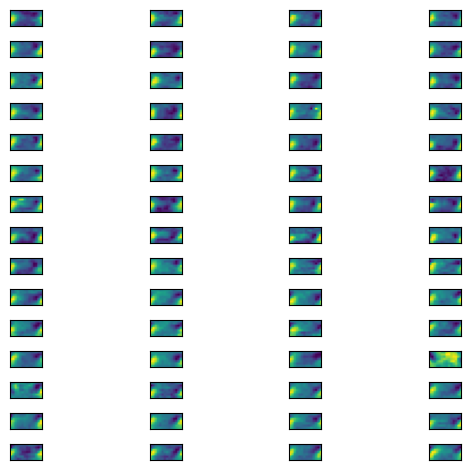

In [16]:
fig, axes = plt.subplots(15, 4)
for i, ax in enumerate(axes.flatten()):
    ax.imshow(xbars.reshape(xbars.shape[0]*xbars.shape[1], xbars.shape[2], xbars.shape[3])[i])
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
plt.show()

13


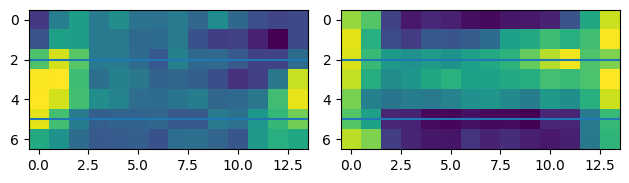

In [33]:
i = 100
xbars_flat = xbars.reshape(xbars.shape[0]*xbars.shape[1], xbars.shape[2], xbars.shape[3])
xbars_AFM_flat = AFM_xbars.reshape(xbars.shape[0]*xbars.shape[1], xbars.shape[2], xbars.shape[3])
lx = 13
ly = 13

fig, axes = plt.subplots(1, 2)
axes[0].imshow(xbars_flat[i])
axes[1].imshow(xbars_AFM_flat[i])
axes[0].axhline(2)
axes[0].axhline(5)
axes[1].axhline(2)
axes[1].axhline(5)
print(ly)
# axes[1].axvline(int(lx/2))
# axes[1].axvline(np.ceil(3*lx/2))
# axes[0].axvline(int(lx/2))
# axes[0].axvline(np.ceil(3*lx/2))
# axes[0].axhline(ly)
# axes[0].axhline(int(3*ly/4))
# axes[0].axhline(int(5*ly/4))
# axes[1].axhline(ly)
# axes[1].axhline(int(3*ly/4))
# axes[1].axhline(int(5*ly/4))
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()
plt.show()

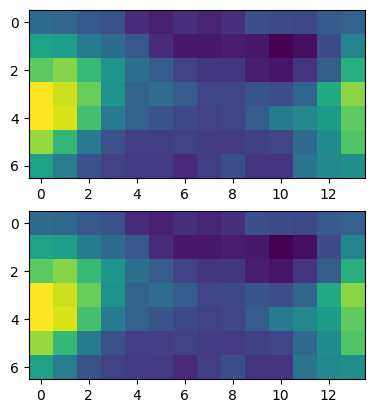

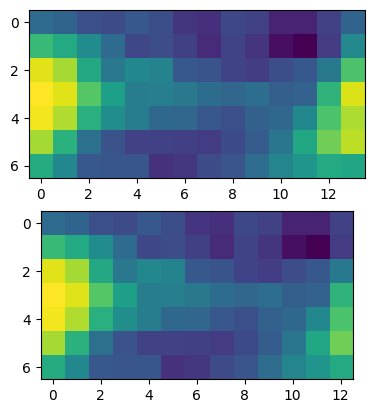

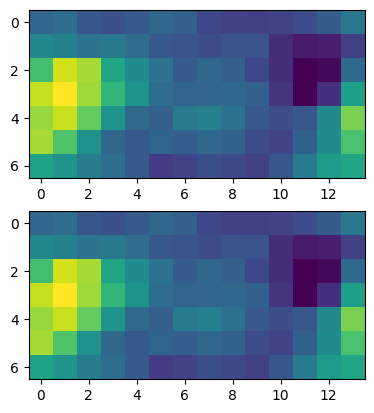

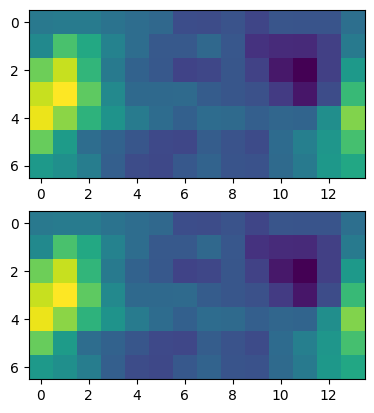

In [103]:
i = 0
xbars_flat = [xbar for lst in xbars for xbar in lst] # xbars.reshape(xbars.shape[0]*xbars.shape[1], xbars.shape[2], xbars.shape[3])
# xbars_test_flat = [xbar_test for lst in xbars_test for xbar_test in lst] # xbars_test.reshape(xbars.shape[0]*xbars.shape[1], xbars.shape[2], xbars.shape[3])
lx = 13
ly = 13

fig, axes = plt.subplots(2, 1)
axes[0].imshow(xbars_flat[i])
axes[1].imshow(xbars_test[i])
plt.show()
fig, axes = plt.subplots(2, 1)
axes[0].imshow(xbars_flat[i + 1])
axes[1].imshow(xbars_test[i + 1])
plt.show()
fig, axes = plt.subplots(2, 1)
axes[0].imshow(xbars_flat[i + 2])
axes[1].imshow(xbars_test[i + 2])
plt.show()
fig, axes = plt.subplots(2, 1)
axes[0].imshow(xbars_flat[i + 3])
axes[1].imshow(xbars_test[i + 3])
plt.show()
# axes[0,1].imshow(xbars_flat[i+1])
# axes[1,1].imshow(xbars_test[i+1])
# axes[0,2].imshow(xbars_flat[i+1])
# axes[1,2].imshow(xbars_test[i+1])
# axes[0,3].imshow(xbars_flat[i+1])
# axes[1,3].imshow(xbars_test[i+1])
# axes[1].axvline(int(lx/2))
# axes[1].axvline(np.ceil(3*lx/2))
# axes[0].axvline(int(lx/2))
# axes[0].axvline(np.ceil(3*lx/2))
# axes[0].axhline(ly)
# axes[0].axhline(int(3*ly/4))
# axes[0].axhline(int(5*ly/4))
# axes[1].axhline(ly)
# axes[1].axhline(int(3*ly/4))
# axes[1].axhline(int(5*ly/4))
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()
plt.show()

# Create a dataset of vertices. All vertices in reference image are fully saturated

In [6]:
ref_imgs = vrtx_box.reshape(vrtx_box.shape[0]*vrtx_box.shape[1], vrtx_box.shape[2], vrtx_box.shape[3])
labels = [1. for i in range(vrtx_box.shape[0]*vrtx_box.shape[1])]


In [ ]:
# change to focus on bar box
# train classifier for various types 

# Testing adaptation to bar box instead of vertex box

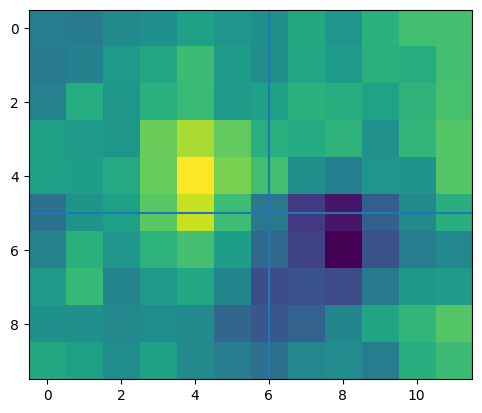

(10, 12)


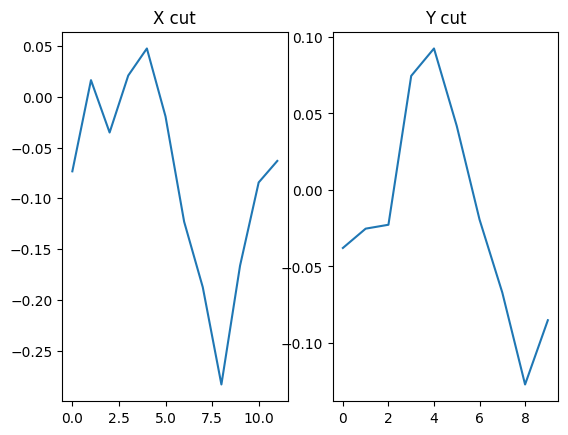

In [11]:
vrtx_flat = vrtx_box.reshape(vrtx_box.shape[0]*vrtx_box.shape[1], vrtx_box.shape[2], vrtx_box.shape[3])
ex = vrtx_flat[1]
x0 = int(ex.shape[1]/2)
y0 = int(ex.shape[0]/2)
fix, ax = plt.subplots()
ax.imshow(ex)
ax.axvline(x0)
ax.axhline(y0)
plt.show()

print(ex.shape)
fig, ax = plt.subplots(1,2)
ax[0].plot(ex[x0])
ax[1].plot(ex[:,y0])
ax[0].set_title('X cut')
ax[1].set_title('Y cut')
plt.show()

